In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("USA_Housing.csv")
X = data.drop(columns=['Price']).values
y = data['Price'].values.reshape(-1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []
beta_matrices = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_aug = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_test_aug = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
    beta = np.linalg.inv(X_train_aug.T @ X_train_aug) @ (X_train_aug.T @ y_train)
    y_pred = X_test_aug @ beta
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    beta_matrices.append(beta)

In [4]:
best_index = np.argmax(r2_scores)
best_beta = beta_matrices[best_index]
print("5-Fold R² Scores:", r2_scores)
print("Best Fold Index:", best_index + 1)
print("Best R² Score:", r2_scores[best_index])

5-Fold R² Scores: [0.9179971706985147, 0.9145677884802819, 0.9116116385364478, 0.9193091764960817, 0.9243869413350317]
Best Fold Index: 5
Best R² Score: 0.9243869413350317


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=True
)
X_train_aug = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_aug = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
beta_final = np.linalg.inv(X_train_aug.T @ X_train_aug) @ (X_train_aug.T @ y_train)
y_pred_final = X_test_aug @ beta_final
final_r2 = r2_score(y_test, y_pred_final)
print("\nFinal R² Score (70/30 split):", final_r2)




Final R² Score (70/30 split): 0.9146818498916266


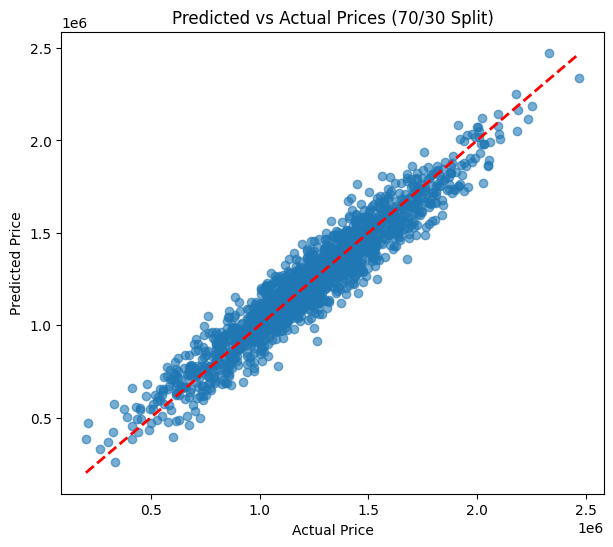

In [6]:
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred_final, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices (70/30 Split)")
plt.show()

Solution 2


In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=42)

In [9]:
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val   = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
X_test  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

In [10]:
def gradient_descent(X, y, alpha, iterations=1000):
    m, n = X.shape
    beta = np.zeros((n, 1))
    for _ in range(iterations):
        gradients = (1/m) * (X.T @ (X @ beta - y))
        beta -= alpha * gradients
    return beta

In [11]:
learning_rates = [0.001, 0.01, 0.1, 1]
results = {}

for lr in learning_rates:
    beta = gradient_descent(X_train, y_train, alpha=lr, iterations=1000)

    y_val_pred = X_val @ beta
    y_test_pred = X_test @ beta
    r2_val = r2_score(y_val, y_val_pred)
    r2_test = r2_score(y_test, y_test_pred)
    results[lr] = {
        "beta": beta.flatten(),
        "R2_val": r2_val,
        "R2_test": r2_test
    }
best_lr = max(results, key=lambda x: results[x]["R2_val"])
best_result = results[best_lr]

print("\nValidation Set Approach with Gradient Descent")
print("=============================================")
for lr, res in results.items():
    print(f"LR={lr} -> R2_val={res['R2_val']:.4f}, R2_test={res['R2_test']:.4f}")
print("\nBest Learning Rate:", best_lr)
print("Best Validation R²:", best_result["R2_val"])
print("Best Test R²:", best_result["R2_test"])
print("Best Beta Coefficients (first few):", best_result["beta"][:6], "...")


Validation Set Approach with Gradient Descent
LR=0.001 -> R2_val=-0.8125, R2_test=-0.9914
LR=0.01 -> R2_val=0.9098, R2_test=0.9147
LR=0.1 -> R2_val=0.9098, R2_test=0.9148
LR=1 -> R2_val=0.9098, R2_test=0.9148

Best Learning Rate: 0.01
Best Validation R²: 0.9098183094422969
Best Test R²: 0.9147434800538763
Best Beta Coefficients (first few): [1232562.51254919  230048.76664688  163686.93503606  121406.94107918
    3117.47363933  150655.97459714] ...


Question 3


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA

In [13]:
columns = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration", "num_doors",
           "body_style", "drive_wheels", "engine_location", "wheel_base", "length", "width",
           "height", "curb_weight", "engine_type", "num_cylinders", "engine_size", "fuel_system",
           "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm", "city_mpg",
           "highway_mpg", "price"]

In [14]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"
df = pd.read_csv(url, names=columns, na_values="?")

In [15]:
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)


/tmp/ipython-input-152432496.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipython-input-152432496.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [16]:
df.dropna(subset=["price"], inplace=True)
df["price"] = df["price"].astype(float)

In [17]:
word_to_num = {"two": 2, "three": 3, "four": 4, "five": 5, "six": 6, "eight": 8, "twelve": 12}
df["num_doors"] = df["num_doors"].replace(word_to_num)
df["num_cylinders"] = df["num_cylinders"].replace(word_to_num)

/tmp/ipython-input-2859624107.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["num_doors"] = df["num_doors"].replace(word_to_num)
/tmp/ipython-input-2859624107.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["num_cylinders"] = df["num_cylinders"].replace(word_to_num)


In [18]:
df = pd.get_dummies(df, columns=["body_style", "drive_wheels"], drop_first=True)


In [19]:
label_cols = ["make", "aspiration", "engine_location", "fuel_type"]
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])


In [20]:
df["fuel_system"] = df["fuel_system"].apply(lambda x: 1 if "pfi" in str(x).lower() else 0)
df["engine_type"] = df["engine_type"].apply(lambda x: 1 if "ohc" in str(x).lower() else 0)
# 4. Divide dataset into features and target
X = df.drop("price", axis=1)
y = df["price"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 5. Train-test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
# Train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Predictions
y_pred = lr.predict(X_test)
print("Without PCA:")
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=42)
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = lr_pca.predict(X_test_pca)
print("\nWith PCA:")
print("R2 Score:", r2_score(y_test_pca, y_pred_pca))
print("RMSE:", np.sqrt(mean_squared_error(y_test_pca, y_pred_pca)))

Without PCA:
R2 Score: 0.804442243576259
RMSE: 3663.6361161737323

With PCA:
R2 Score: 0.7500675882701553
RMSE: 4141.771149282544
